## Q1. Median Maintenance using a Heap


### Part 1

Implement a "dominant heap" class `BinaryHeap`, which can handle both the min heap and the max heap cases, by having the constructor explicitly pass the "comparison" operator in. Replace min and del_min by dominant and del_dominant methods. Change the classmethod to also take in the operator.

In [1]:
#your code here
class BinaryHeap:
    """
    A heap implementation that can handle both the min heap and the max heap
    cases. It accomplishes this by having the comparison operator passed in
    via the class constructor. 
    
    Parameters
    ----------
    storage : list
        a list of the data elements of the heap
    upto: int
        represents the number of elements in the heap
    comparison_operator: operator, default is set to 'lt'
        used to determine if the min or max heap case should be used
        
    Notes
    -----
    PRE: the list of data elements provided, as parameter 'it', 
        must be comparable: implement < and ==)
    POST: the dataset list is not changed by operations of this 
        class (immutable)
    INVARIANTS:
        - If an element is present in the provided list, the element is
        present in the heap/self.storage
        - 
          
    Examples
    --------
    >>> data = [1,8,5,9,23,2,45,6,7,99,-5]
    >>> from operator import gt, lt
    >>> bh = BinaryHeap.heapify_slow(data, lt)
    >>> print(bh.storage)
    [None, -5, 1, 2, 7, 6, 5, 45, 9, 8, 99, 23]
    >>> bh.dominant()
    -5
    >>> bh = BinaryHeap.heapify_slow(data, gt)
    >>> print(bh.storage)
    [None, 99, 45, 23, 7, 9, 2, 5, 1, 6, 8, -5]
    >>> bh.dominant()
    99
    """
    def __init__(self):
        self.storage=[None]
        self.upto=0
        # set the default to the less than 'lt' operator
        self.comparison_operator=lt
        
    @classmethod
    def heapify_slow(cls, it, comparison_operator):
        inst = cls()
        # set the comparison operator related with this class method
        inst.comparison_operator = comparison_operator
        for i in it:
            inst.insert(i)
        return inst
            
    def insert(self, value):
        self.storage.append(value)
        self.upto += 1
        self.sift_up(self.upto)

    def sift_up(self, i):
        parent = i // 2
        # check if the parent is greater than 0 and use the comparison operator provided to 
        # the class at instantiation to determine if the sift up should occur
        if parent > 0 and self.comparison_operator(self.storage[i], self.storage[parent]):
            self.storage[i], self.storage[parent] = self.storage[parent], self.storage[i]
            self.sift_up(parent)
     
    def _dominant_child(self, i):
        if 2*i + 1 > self.upto:
            return 2*i
        else:
            l = (self.storage[2*i], self.storage[2*i+1])
            # the comparison operator determines if min or max is used 
            if self.comparison_operator is lt:
                return 2*i + l.index(min(l))
            else:
                return 2*i + l.index(max(l))
    
    def sift_down(self, i):
        if 2*i <= self.upto:
            child = self._dominant_child(i) 
            # the comparison operator determines if the comparison made justifies a sift down
            if not self.comparison_operator(self.storage[i], self.storage[child]):
                self.storage[child], self.storage[i] = self.storage[i], self.storage[child]
                self.sift_down(child)
    
    def dominant(self): 
        """
        A class method to return the 'dominant' element of the heap's internal storage.

        Returns
        -------
        self.storage[1]: int
            the 'dominant' element in the heap's internal storage

        Notes
        -----
        INVARIANTS:
            - If the element is present in the heap and it is delcared as
            'dominant', this method will return it
        """
        return self.storage[1]
        
    def del_dominant(self): 
        """
        A class method to delete the 'dominant' element of the heap's internal storage. 

        Returns
        -------
        dominant_val: int
            the deleted 'dominant' value

        Notes
        -----
        INVARIANTS:
            - If the request to delete the dominant value is made, the item is no longer
            present in the heap.
        """
        # get the dominant value from the first position of the internal list
        dominant_val = self.storage[1]
        self.storage[1], self.storage[self.upto] = self.storage[self.upto], self.storage[1]
        # pop the value off of the internal storage
        self.storage.pop()
        # there is now one less item, adjust the element count
        self.upto -= 1
        self.sift_down(1)
        return dominant_val

In [2]:
data = [1,8,5,9,23,2,45,6,7,99,-5]

In [3]:
from operator import gt, lt
bh = BinaryHeap.heapify_slow(data, lt)
print(bh.storage)
bh.dominant()

[None, -5, 1, 2, 7, 6, 5, 45, 9, 8, 99, 23]


-5

In [4]:
bh = BinaryHeap.heapify_slow(data, gt)
print(bh.storage)
bh.dominant()

[None, 99, 45, 23, 7, 9, 2, 5, 1, 6, 8, -5]


99

### Part 2

Median maintenance is a very cool algorithm to find an online median.
We create two arrays to test our implementation, using np.median to test our answer...

In [5]:
import random
import numpy as np
l = [random.randint(1,1000) for _ in range(150)]
print(len(l), np.median(l))
l2 = l + [random.randint(1,1000)]
print(len(l2), np.median(l2))

150 548.5
151 549.0


You will implement def online_median(iterator) which is a generator yielding successive values of your online median.

The algorithm is as follows:

We'll use 2 heaps, a max heap for the lower half of the data, and a min-heap for the upper half. We take the first 2values in our data and assign the smaller value to the max heap, while the larger value goes to the min-heap. Then, as we "insert" subsequent values in one of the two heaps, the following holds: if we keep the number of elements in both heaps equal (for the even case) or at-most differing by one, the median is respectively the average of the two dominants or the dominant in the heap with one extra item.

What then is our strategy for this balanced insertion? Quite simple really: if a new value is not as dominant as the dominant value, add it to that heap. If it is more dominant, add it to the other. If two items in a row get added to the same heap, the heaps will be out of balance by more than one. In this case, take the dominant element from the larger heap and simply add it to the smaller one.

In [6]:
#your code here
def online_median(iterator):
    """
    An algorithm that uses a generator to yield successive values of the online median.  
    
    Parameters
    ----------
    l : iterator
        the incoming data values used to determine the online median provided as an iterator
        
    Yields
    -------
    median: int
        the median value at any point in the online median generator's processing
        
    Notes
    -----
    PRE: The dataset associated with the provided iterator 
        must contain elements that are comparable: implement < and ==) 
        
    INVARIANTS:
        - If an element is provided to the online_median function, it will be present
            in one of the two internal heaps (max or min)
          
    Examples
    --------
    >>> import random
    >>> import numpy as np
    >>> l = [random.randint(1,1000) for _ in range(150)]
    >>> l2 = l + [random.randint(1,1000)]
    >>> list(online_median(iter(l2)))[-1]
    572
    """
    # check for a valid length before proceeding (should be > 1)
    if len(l) < 1:
        raise ValueError('Cannot find the online median of an empty dataset.')
    # if length is only 1, we set the median to the sole value
    elif len(l) == 1:
        median = next(iterator)
        yield median
    else: 
        first_value = next(iterator)
        second_value = next(iterator)
        # set the smaller value to the max heap
        # and the larger value to the min heap
        max_heap = BinaryHeap.heapify_slow([min(first_value, second_value)], gt)
        min_heap = BinaryHeap.heapify_slow([max(first_value, second_value)], lt)
        
        # numerical value to represent state of balance
        # if the balance_value is 0, the two heaps are balanced
        balance_value = 0
        
    for i in iterator: 
        # INSERTION to max heap - new value is not as dominant as the current dominant
        if (i < max_heap.dominant()):
            max_heap.insert(i)
        
            # balance value is 1, move value from max heap to min heap and decrement balance
            # value to set as two heaps are balanced
            if balance_value is 1: 
                min_heap.insert(max_heap.dominant())
                max_heap.del_dominant()
                balance_value -= 1
            else:
                # balance value is set to 0, increment to 1 after max heap insert
                balance_value += 1
        else: 
            # INSERTION to min heap
            min_heap.insert(i)
            
            # balance value is -1, move min heap dominant to max heap and set
            # as two heaps are balanced i.e. balance_value == 0
            if balance_value is -1:
                max_heap.insert(min_heap.dominant())
                min_heap.del_dominant()
                balance_value += 1
            else:
                # balance value is set to 0, decrement to -1
                balance_value += -1
                
        # the median is the dominant in the heap with one extra item
        if max_heap.upto > min_heap.upto:
            median = max_heap.dominant()
        elif min_heap.upto > max_heap.upto:
            median = min_heap.dominant()
        # the two heaps contain the same amount of elements therefore the median
        # is the average of the two heap's dominants
        else: 
            median = (min_heap.dominant() + max_heap.dominant()) / 2
        
        yield median

Do your answers match?


548.5


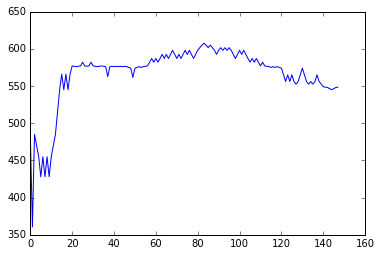

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
medians = list(online_median(iter(l)))
print(medians[-1])
plt.plot(medians)

In [8]:
list(online_median(iter(l2)))[-1]

549

Lastly, lets repeat the analysis we did last time on the randomly generated data.

In [9]:
from random import normalvariate, random
from itertools import count
def make_data(m, stop=None):
    for _ in count():
        if stop and _ > stop:
            break
        yield 1.0e09 + normalvariate(0, m*random() )

In [10]:
g = online_median(make_data(5, 100))
print(type(g))
out = list(g)
out[-10:]

<class 'generator'>


[999999999.8039548,
 999999999.794616,
 999999999.793423,
 999999999.7922301,
 999999999.793423,
 999999999.7922301,
 999999999.793423,
 999999999.794616,
 999999999.8039548,
 999999999.8132938]

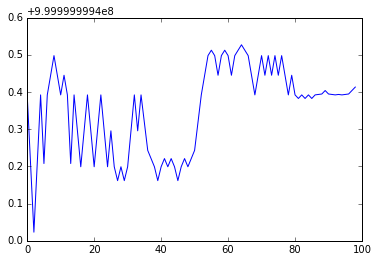

In [11]:
plt.plot(out)

## Q2

### Simulating a flight check-in counter

It is your job to simulate a flight-checkin counter. There are m agents handling n passengers. The passengers arrive in line with in-between time given by an exponential distribution for INTER_ARRIVAL_TIME. Each passenger, once he or she gets to a counter, is processed in a time drawn from an exponential distribution with PROCESSING_TIME. 

Clearly, in the usual case of 3-4 agents and 200+ customers on a flight, the customer waits much longer. We have been hired by the airlines customer-relations group to see how many extra agents must we hire to reduce waiting times by how much.

We start by representing each customer by a co-routine, which starts with the `inline` event. The state changes to the `atcounter` event, and then `ptime` seconds later, to the `leaves` event. Notice how this customer "process" is stopped at the yield, until the customer can be handled.

In [12]:
import collections, random
Event = collections.namedtuple('Event', 'time cid action agent')
def customer_process(idee, start, ptime):
    t, agent = yield Event(start, idee, "inline", None)
    t, agent = yield Event(t, idee, "atcounter", agent)
    yield Event(t+ptime, idee, "leaves", agent)          

The following function simply implements the draw from the exponential distribution for a given customer:

In [13]:
def duration(arr_time, service_time):
    return random.expovariate(1./arr_time), random.expovariate(1./service_time)

Here is out main simulation class. you will be filling in parts of this class.

The constructor sets up the simulation. Three queues are created, one for agents that become free, one priority queue for events so that they can be processed in the order recieved, and a backlog for queue for those customers waiting in line because no agent was available.

We set up all the customers in the constructor, with two dictionaries, one to hold the co-routines, and one to hold time metadata which we shall use to figure the average waiting time.

The `run` method is where all the action happens and is the one you will edit.

In [14]:
import queue
import logging

# create a logger and add the StreamHandler instance to send messages to
# streams for output
logger = logging.getLogger()
logger.addHandler(logging.StreamHandler())

class Simulator:
    
    def __init__(self, n_agents, n_customers, INTER_ARRIVAL_TIME =1., PROCESSING_TIME=3., DEBUG=False ): 
        #queues
        self.free_agents = queue.Queue()
        self.backlog = queue.Queue()
        self.events=queue.PriorityQueue()
        #save the arguments
        self.n_customers = n_customers
        self.n_agents = n_agents
        self.intertime=INTER_ARRIVAL_TIME
        self.proctime=PROCESSING_TIME
        #dictionaries to hold customer process
        self.customers={}
        self.customer_meta={}
        self.logger = logging.getLogger("sim")
        if DEBUG:
            self.logger.setLevel(logging.DEBUG)
        else:
            self.logger.setLevel(logging.WARNING)
        #on the free_agents queue, we put all the agents, and thee time
        #they got free
        for i in range(n_agents):
            self.free_agents.put((i,0))
        #this tracks when each customer came in.          
        time_when_came=0.
        for j in range(n_customers):
            interarrtime, proctime = duration(self.intertime, self.proctime)
            time_when_came += interarrtime
            intuple = (j, time_when_came, proctime)
            c = customer_process(*intuple)
            self.logger.debug("Customer {}, arrived {}, will take {} at counter".format(*intuple))
            #add each customer to dictionaries
            self.customers[j]=c
            self.customer_meta[j]={'cid':j, 'start':time_when_came, 'finish':None}
        self.logger.debug("========ending init==============\n\n")
        self.max_time_when_came=time_when_came  

    def run(self, end_time):
        #we prime each customer co-routine at the start
        #and put that event in the events priority queue
        #Since an event is a tuple, the ordering will be by start time
        for cid, proc in sorted(self.customers.items()):
            first_event = next(proc)#prime
            self.events.put(first_event)#customer in line

        #start at time 0
        sim_time = 0
        while sim_time < end_time:
            #we are done if no events and no backlog
            if self.events.empty() and self.backlog.empty(): 
                self.logger.debug('*** end of events and backlog***') 
                break
            #if we have agents available and a backlog
            #take customer from backlog queue. This is equivalent
            #to taking customers from line
            if not self.backlog.empty() and not self.free_agents.empty():
                "YOUR CODE HERE"
                # get the next customer from the backlog queue
                current_event = self.backlog.get()
                
                #the sim time from this branch will be false
                #as we get the old time the person in the line showed up
            else: #get current event in all other cases
                #his ensures that leave events are processed thus
                #freeing up agents
                "YOUR CODE HERE"
                # get the next event in the priority queue
                current_event = self.events.get()
            
            sim_time, cid, action, agent = current_event

            #get the current customer process
            # use exception handling to catch KeyError gracefully 
            try:
                cproc = self.customers[cid]
            except Exception:
                print("KeyError Occurred!: ", self.customers, cid)
                
            # set next_time to -1
            # used to determine if an atcounter action has set next_time to sim_time below
            next_time = -1
                
            if action=='leaves':
                self.logger.debug(">>>Customer {} leaves, agent {} free at {}".format(cid, agent, sim_time))
                #an agent gets free. Put the time they got free on q
                #also update the metadata
                self.free_agents.put((agent, sim_time))
                self.customer_meta[cid]['finish']=sim_time
            elif action=='atcounter':
                self.logger.debug("Customer {} atcounter Agent {} at {}".format(cid, agent, sim_time))
                next_time = sim_time#processing time already in coroutine
            elif action=='inline':#the agent is None to start
                self.logger.debug('----------------------------------------------')
                self.logger.debug("Customer {}, arrived in line @ {}.".format(cid, sim_time))

                if self.free_agents.empty():
                    self.logger.debug("NO agents available, putting {} inline on backlog at {}".format(cid, sim_time))
                    "YOUR CODE HERE"
                    # add the event to the backlog queue
                    self.backlog.put(current_event)
      
                else:
                    self.logger.debug("{} agents available to serve.".format(self.free_agents.qsize()))
                    "YOUR CODE HERE"#handle both situations
                    #of getting from backlog or regular. The time in
                    #next_time which you will send in message to co-routine
                    #below are different
                    
                    # get the free agent and determine next_time by selecting the 
                    # max value between sim_time and t
                    # this is how both situations are handled
                    (agent, t) = self.free_agents.get()
                    next_time = max(sim_time, t)
                    
                    self.logger.debug("Customer {} inline to be served by Agent {} at {}".format(cid, agent, next_time))

            #drive the co-routine by sending in time and agent, and getting
            #next event out. The event is put into the priority queue.

            # next_time is set, proceed with next_event by sending in time and agent
            if next_time != -1:
                try:
                    next_event = cproc.send((next_time, agent)) 
                except StopIteration:
                    del self.customers[cid] 
                else:
                    self.events.put(next_event)
                
    def compute_ptimes(self):
        ptimes=[]
        for j in range(self.n_customers):
            #print(j,self.customer_meta[j] )
            if self.customer_meta[j]['finish']!=None:
                ptimes.append(self.customer_meta[j]['finish'] - self.customer_meta[j]['start'])
        return ptimes

In [15]:
def sim_main(num_agents, num_customers, extratime=20., seed=None, debug=False):
    if seed is not None:
        random.seed(seed)
    sim = Simulator(num_agents, num_customers, DEBUG=debug)
    sim.run(sim.max_time_when_came+extratime)
    return sim

Start small to test this out.

In [16]:
sim=sim_main(2,6, debug=True)

Customer 0, arrived 0.15560524199604805, will take 0.908474154267085 at counter
Customer 1, arrived 0.4830938545981279, will take 0.38815505679813506 at counter
Customer 2, arrived 0.5973303944060777, will take 1.7754316764531894 at counter
Customer 3, arrived 1.0693020275302125, will take 7.176553132891631 at counter
Customer 4, arrived 1.1692615345133692, will take 1.3932597189006024 at counter
Customer 5, arrived 1.5091991984588289, will take 1.9828319119036097 at counter
========ending init==============


----------------------------------------------
Customer 0, arrived in line @ 0.15560524199604805.
2 agents available to serve.
Customer 0 inline to be served by Agent 0 at 0.15560524199604805
Customer 0 atcounter Agent 0 at 0.15560524199604805
----------------------------------------------
Customer 1, arrived in line @ 0.4830938545981279.
1 agents available to serve.
Customer 1 inline to be served by Agent 1 at 0.4830938545981279
Customer 1 atcounter Agent 1 at 0.4830938545981279

Now lets try it with some larger numbers.

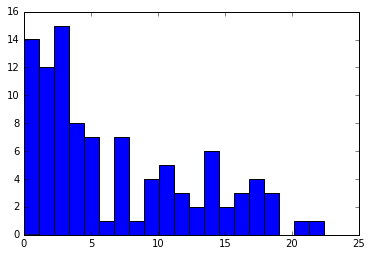

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
sim=sim_main(3,100)
plt.hist(sim.compute_ptimes(), bins=20);

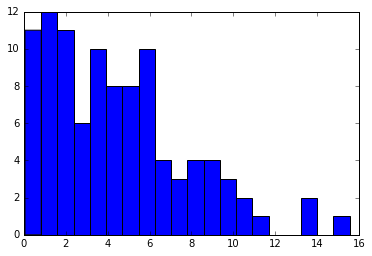

In [18]:
sim2=sim_main(4,100)
plt.hist(sim2.compute_ptimes(), bins=20);

extra time needed below as with 400 passengers a long time is taken to process.

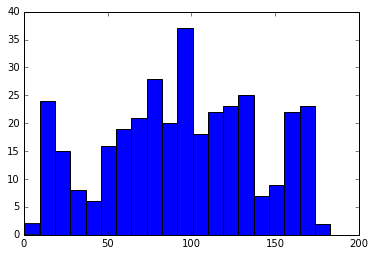

In [19]:
sim2=sim_main(2,400, extratime=100)
plt.hist(sim2.compute_ptimes(), bins=20);

For a proper statistical analysis, you would want to draw this multiple times and look at the distribution of the averages as well. But you should know what this distribution is :-).